# 使用RNN来生成莎士比亚风格的句子

这个例子会用莎士比亚的著作来训练一个char-level RNN语言模型，同时使用它来生成莎士比亚风格的句子。

## 数据准备

输入文件是纯文本文件，我们会使用unidecode来把unicode转成ASCII文本。

In [2]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('../data/shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1115393


这个文件太大了，我们随机的进行截断。

In [3]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

d madly play with my forefather's joints?
And pluck the mangled Tybalt from his shroud?
And, in this rage, with some great kinsman's bone,
As with a club, dash out my desperate brains?
O, look! methink


## 定义模型

回忆一下之前的Char RNN 分类器，我们是“手动”实现的最朴素的RNN，现在我们使用更加先进的GRU。
另外之前是没有Embedding的，直接用字母的one-hot作为输入。

In [4]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

## 输入和输出

每个chunk会变成一个LongTensor，做法是遍历每一个字母然后把它变成all_characters里的下标。

In [5]:
# 把string变成LongTensor
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

Variable containing:
 10
 11
 12
 39
 40
 41
[torch.LongTensor of size 6]



最后我们随机的选择一个字符串作为训练数据，输入是字符串的第一个字母到倒数第二个字母，而输出是从第二个字母到最后一个字母。比如字符串是"abc"，那么输入就是"ab"，输出是"bc"

In [6]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

## 生成句子

为了评估模型生成的效果，我们首先需要让它来生成一些句子

In [7]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # 假设输入的前缀是字符串prime_str，先用它来改变隐状态
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # 根据输出概率采样
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # 用上一个输出作为下一轮的输入
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

## 训练

一些工具函数

In [8]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

训练函数：

In [9]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    decoder_optimizer.step()

    return loss.data[0] / chunk_len

接下来我们定义训练的参数，初始化模型，开始训练：

In [10]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 18s (100 5%) 2.2827]
Whide alill ther, mowe orr of our ha sortharest wours.

BRGEUE:
Thant ad shat wilam.

NUOUTES:
UARCGAO 

 36s (200 10%) 2.1202]
Why ETS: dook the fate
att my the thou, the the thim ome git wou pexend,
Whiters to mou go thh't sere  

 54s (300 15%) 2.1851]
Which not share,
Whart of him gand to mus to maks resonce honte soo, shath fill hir:
Thou frospay woec 

 11s (400 20%) 1.9829]
Wher kince, the deece
And here some, hy on ope gor to and onter be gread, weand;
O man not the deared  

 29s (500 25%) 1.9515]
Whis this do
ocrise, und you dies my of my for quppent ound their the war;
Hike bist wid a my.

SENTEO 

 47s (600 30%) 1.8638]
Whing thear vire.

DUKES,--
Whones theen the sear coom of me.

GLOUCESTER:
Whother to thes the ficts,  

 5s (700 35%) 1.9786]
When hannice not streten for and him.

CLORCEO:
Nour all heare Maalder for the herevey undies.

DUKE Y 

 23s (800 40%) 1.9238]
Whath offees there the shoall by forth do go,
the perunts. But the to the pooneffor

## 损失变化图

查看损失在训练过程中的变化有助于我们了解学习的过程。

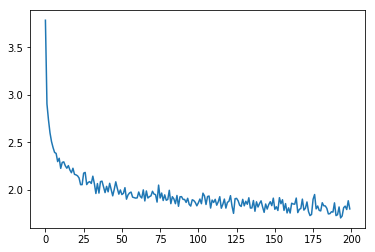

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## 测试

In [12]:
print(evaluate('Th', 200, temperature=0.8))

Ther
you go what loved ancut that me to the werefered all your to they
That the pessce, shap treed for time sok theie chator
The vuent tere my treance her will not youe
Which my bessin, shall brie lans 


In [13]:
print(evaluate('Th', 200, temperature=0.2))

There the with the count the with the for the mean the with the mean:
They with the with the with the counto the with the for the say,
The wear the be suppers the with the with the count the with the wa
